# Разработка стратегии взаимодействия с клиентами на основе аналитических данных для сети фитнес-центров «Культурист-датасаентист»

Целью данного исследования является разработка стратегии взаимодействия с клиентами на основе аналитических данных для сети фитнес-центров «Культурист-датасаентист» с целью уменьшения оттока клиентов. 

В рамках данного исследования будут использоваться данные, полученные из множество клиентских анкет, в электронный виде. Будет проведён анализ, а впоследствии подготовлен план действий по удержанию клиентов. 
В рамках данного плана поставлены следующие цели:

* научиться прогнозировать вероятность оттока для каждого клиента (на уровне следующего месяца);
* сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* проанализировать основные признаки, наиболее сильно влияющие на отток;
* сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
      
        1) выделить целевые группы клиентов;
        2) предложить меры по снижению оттока;
        3) определить другие особенности взаимодействия с клиентами.


Структура анализа следующая:
* Глава 1 посвящена подготовке к анализу - загрузке необходимых библиотек, датафреймов, проведению первичного анализа;
* В Главе 2 будет проведён исследовательский анализ данных;
* В Главе 3 будет построена модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце;
* Четвёртая глава посвящена кластеризации клиентов и выявлению особенностей отдельных кластеров, с целью определения плана действий по удержанию клиентов;
* В пятой главе будут подведены итоги, сделаны выводы и даны рекомендации по стратегии взаимодействия с клиентами.

## Подготовка к анализу

Сначала необходимо загрузить необходимые библиотеки, датафрейм, провести первичный анализ данных.

Загрузка библиотек и файла с данными (имя файла с данными - gym):

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random
from math import sqrt
import math 
from scipy import stats as st
from scipy.stats import binom, norm
import scipy.stats as stats
from datetime import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage 
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.2f}'.format

Создание универсальной функции для анализа:

In [3]:
def first_analysis(data):
    print(data.shape)
    data.info()
    print(data.describe())
    display(data.head())
    print(data.duplicated().sum())

In [4]:
first_analysis(gym)

(4000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-n

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


0


Датафрейм содержит 4000 строк и 14 столбцов.

Названия колонок:
* gender —  пол;
* Near_Location — проживание или работа в районе, где находится фитнес-центр;
* Partner — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
* Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использование промо-кода от знакомого при оплате первого абонемента);
* Phone — наличие контактного телефона;
* Age — возраст;
* Lifetime — время с момента первого обращения в фитнес-центр (в месяцах);
* Contract_period — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
* Month_to_end_contract — срок до окончания текущего действующего абонемента (в месяцах);
* Group_visits — факт посещения групповых занятий;
* Avg_class_frequency_total — средняя частота посещений в неделю за все время с начала действия абонемента;
* Avg_class_frequency_current_month — средняя частота посещений в неделю за предыдущий месяц;
* Avg_additional_charges_total — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон;
* Churn — факт оттока в текущем месяце.

Пропусков нет, дубликатов нет. Названия столбцов следует переписать в соответствии со "змеиным стилем". 

In [5]:
gym.columns = gym.columns.str.lower()
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


In [6]:
gym.mean()

gender                                0.51
near_location                         0.85
partner                               0.49
promo_friends                         0.31
phone                                 0.90
contract_period                       4.68
group_visits                          0.41
age                                  29.18
avg_additional_charges_total        146.94
month_to_end_contract                 4.32
lifetime                              3.72
avg_class_frequency_total             1.88
avg_class_frequency_current_month     1.77
churn                                 0.27
dtype: float64

Переименование колонок прошло успешно.

**Cредние значения и стандартные отклонения**

Средние значения логических типов данных говорят о следующем:

* в выборке 51% клиентов являются мужчинами, остальные женщины (столбец gender). Стандартное отклонение очень высокое из-за почти одинакого количества людей обоих полов и составляет 0,50; 
* 85% клиентов проживают или работают в районе, где находится фитнес-центр. Отклонение составляет 0,36 (столбец near_location);
* 49 % клиентов - сотрудники компаний, получивших скидки на абонемент. Стандартное отклонение также составило 0,50 (столбец partner);
* 31% клиентов использовали промо-код от знакомого при оплате первого абонемента. Стандартное отклонение также составило 0,46  (столбец promo_friends);
* 90% клиентов оставили свой номер телефона, стандартное отклонение составило 0,3 (колонка phone);
* 41% клиентов посещали групповые занятия, стандартное отклонение составило 0,49 (колонка group_visits).

Столбцы, содержащие числовые значения, содержат следующую информацию:
* средний возраст клиентов - 29,2 года, стандартное отклонение составило 3,3 (колонка age);
* среднее время с момента первого обращения в фитнес-центр - 3,7 месяца, стандартное отклонение составило 3,75 месяца; Вероятно, одна из причин, почему стандартное отклонение больше среднего значения - наличие одновременно и клиентов, только-только заключивших договор (50% являются клиентами не более 3 месяцев), и лояльных клиентов, посещающих фитнес-зал годами (75% клиентов посещают фитнес-зал более 5 месяцев, "лидер" является клиентом фитнес-зала уже 31 месяц) (колонка lifetime);
* средняя длительность текущего действующего абонемента составляет 4,7 месяцев, стандартное отклонение - 4,55. Это опять говорит о большом разбросе значений: половина контрактов заключена на срок до 1 месяца, 75% контрактов - на срок до 6 месяцев 
(колонка contract_period);
* средний срок до окончания текущего действующего абонемента - 4,3 месяца, стандартное отклонение - 4,19 (колонка month_to_end_contract), что неудивительно при анализе длительности текущих абонементов;
* средняя частота посещений в неделю за все время с начала действия абонемента - 1,9 раз, стандартное отклонение -  0,97   (колонка avg_class_frequency_total);
* средняя частота посещений в неделю за предыдущий месяц - 1,8, стандартное отклонение - 1,05 (колонка avg_class_frequency_current_month);
* средняя суммарная выручка от других услуг фитнес-центра составила 147, стандартное отклонение - 96,36 (колонка avg_additional_charges_total).	

Итоговая колонка churn содержит ключевую информацию для данного исследования в виде логического типа данных:

* 27% клиентов попали в отток, стандартное отклонение - 0,44.

Типы всех имеющихся в датасете признаков - числовые, категориальных нет. 

## Исследовательский анализ данных

Для дальнейшего анализа данные будут сгруппированы в две группы: те, кто ушёл в отток, и те, кто остался.

In [7]:
gym_2 = gym.groupby('churn').mean()
gym_2

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.90,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.90,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


### Анализ клиентов, ушедших в отток, и оставшихся клиентов

Результаты получились следующие:
* в обеих группах процент мужчин составил 51%;
* клиенты, ушедшие в отток, реже жили или работали в том же районе, где располагался фитнес-центр (77% против 87% соответственно);
* клиенты, ушедшие в отток, намного реже являются сотрудниками компаний, с которыми у фитнес-клубов заключены договоры на предоставление скидок (36% против 53% соответственно);
* клиенты, ушедшие в отток, намного реже использовали промо-код от знакомого при оплате первого абонемента (18% против 35% соответственно);
* номера телефонов оставляло одинаковое количество клиентов в обеих группах - 90%;
* длительность текущего абонемента у остающихся клиентов составляет в среднем 5,8 месяца, а у ушедших в отток - 1,7 месяца.
* среди ушедших клиентов намного меньше тех, кто посещал групповые занятия (всего 27%), чем у оставшихся (46%);
* средний возраст клиентов, ушедших в отток - 27 лет. У оставшихся он выше - 30 лет;
* ушедшие в отток клиенты оставляли меньше денег в фитнес-клубе (115 против 158,5 соответственно);
* у ушедших в отток клиентов остаётся меньше месяцев до конца контракта (1,7 месяца), чем у остающихся (5,3 месяца);
* у остающихся клиентов прошло больше месяцев с момента первого обращения, чем у ушедших в отток (4,7 против 1);
* средняя частота посещений в неделю за все время с начала действия абонемента среди ушедших в отток - 1,5, у оставшихся - 2;
* наконец, средняя частота посещений в неделю за предыдущий месяц среди ушедших в отток составила 1, а у оставшихся - 2.

Для лучшей презентации результатов будут построены столбчатые гистограммы для столбцов, содержащих числовые значения, и столбчатые диаграммы для логических типов данных.

### Построение графиков

Для наглядности на каждом графике будут изображены две группы пользователей: те, которые остались (gym_stayed), и те, которые ушли в отток (gym_left).
Для создания графиков необходимо отделить от датафрейма следующие группы:
* Разделить датафрейм gym на тех, кто остался (gym_stayed) и тех, кто ушёл (gym_left).
* Определить список столбцов, содержащих числовые значения, и список столбцов, содержащие логические типы данных.

In [8]:
gym_stayed = gym[gym['churn'] == 0]
gym_left = gym[gym['churn'] == 1]
first_analysis(gym_stayed)

(2939, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2939 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             2939 non-null   int64  
 1   near_location                      2939 non-null   int64  
 2   partner                            2939 non-null   int64  
 3   promo_friends                      2939 non-null   int64  
 4   phone                              2939 non-null   int64  
 5   contract_period                    2939 non-null   int64  
 6   group_visits                       2939 non-null   int64  
 7   age                                2939 non-null   int64  
 8   avg_additional_charges_total       2939 non-null   float64
 9   month_to_end_contract              2939 non-null   float64
 10  lifetime                           2939 non-null   int64  
 11  avg_class_frequency_total          2939 non-n

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12,0


0


In [9]:
first_analysis(gym_left)

(1061, 14)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1061 entries, 7 to 3996
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             1061 non-null   int64  
 1   near_location                      1061 non-null   int64  
 2   partner                            1061 non-null   int64  
 3   promo_friends                      1061 non-null   int64  
 4   phone                              1061 non-null   int64  
 5   contract_period                    1061 non-null   int64  
 6   group_visits                       1061 non-null   int64  
 7   age                                1061 non-null   int64  
 8   avg_additional_charges_total       1061 non-null   float64
 9   month_to_end_contract              1061 non-null   float64
 10  lifetime                           1061 non-null   int64  
 11  avg_class_frequency_total          1061 non-n

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
7,0,1,0,0,1,1,0,30,217.79,1.00,0,1.21,1.05,1
11,1,1,1,0,1,1,0,27,266.78,1.00,2,2.35,1.58,1
13,1,1,0,0,1,1,1,27,152.75,1.00,1,0.00,0.00,1
21,0,0,0,0,1,1,0,30,153.20,1.00,3,0.64,0.00,1
23,1,1,0,0,1,1,1,32,276.08,1.00,1,1.42,1.04,1


0


Деление на оставшихся и на ушедших в отток пользователей прошло успешно. 

Деление на столбцы, содержащие числовые значения, и столбцы, содержащие логические типы данных:

In [10]:
gym_num = gym[['age', 'lifetime', 'contract_period', 'month_to_end_contract', 'avg_class_frequency_total', 
                            'avg_class_frequency_current_month', 'avg_additional_charges_total']]
gym_num.head(5)

,age,lifetime,contract_period,month_to_end_contract,avg_class_frequency_total,avg_class_frequency_current_month,avg_additional_charges_total
0,29,3,6,5.00,0.02,0.00,14.23
1,31,7,12,12.00,1.92,1.91,113.20
2,28,2,1,1.00,1.86,1.74,129.45
3,33,2,12,12.00,3.21,3.36,62.67
4,26,3,1,1.00,1.11,1.12,198.36


In [11]:
gym_bool = gym[~gym.isin(gym_num)].dropna(axis=1)
gym_bool.head(5)

,gender,near_location,partner,promo_friends,phone,group_visits,churn
0,1,1,1,1,0,1,0
1,0,1,0,0,1,1,0
2,0,1,1,0,1,0,0
3,0,1,1,1,1,1,0
4,1,1,1,1,1,0,0


Списки столбцов успешно созданы.

In [12]:
gym_stayed_num = gym_stayed[gym_stayed.isin(gym_num)].dropna(axis=1)
gym_stayed_bool = gym_stayed[gym_stayed.isin(gym_bool)].dropna(axis=1)
gym_stayed_num

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,6,29,14.23,5.00,3,0.02,0.00
1,12,31,113.20,12.00,7,1.92,1.91
2,1,28,129.45,1.00,2,1.86,1.74
3,12,33,62.67,12.00,2,3.21,3.36
4,1,26,198.36,1.00,3,1.11,1.12
...,...,...,...,...,...,...,...
3993,1,33,231.78,1.00,3,1.42,1.45
3995,12,33,2.41,12.00,8,2.28,2.35
3997,12,28,78.25,11.00,2,2.79,2.83
3998,6,32,61.91,5.00,3,1.63,1.60


In [13]:
gym_stayed_bool

,gender,near_location,partner,promo_friends,phone,group_visits,churn
0,1,1,1,1,0,1,0
1,0,1,0,0,1,1,0
2,0,1,1,0,1,0,0
3,0,1,1,1,1,1,0
4,1,1,1,1,1,0,0
...,...,...,...,...,...,...,...
3993,0,1,1,0,1,0,0
3995,1,1,1,0,1,0,0
3997,1,1,1,1,1,0,0
3998,0,1,1,1,1,0,0


In [14]:
gym_left_num = gym_left[gym_left.isin(gym_num)].dropna(axis=1)
gym_left_bool = gym_left[gym_left.isin(gym_bool)].dropna(axis=1)
gym_left_num

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
7,1,30,217.79,1.00,0,1.21,1.05
11,1,27,266.78,1.00,2,2.35,1.58
13,1,27,152.75,1.00,1,0.00,0.00
21,1,30,153.20,1.00,3,0.64,0.00
23,1,32,276.08,1.00,1,1.42,1.04
...,...,...,...,...,...,...,...
3982,1,24,135.40,1.00,0,1.39,0.79
3984,6,22,101.11,6.00,2,1.38,0.34
3986,1,34,226.80,1.00,0,1.40,0.30
3994,1,26,31.07,1.00,1,1.16,0.27


In [15]:
gym_left_bool

,gender,near_location,partner,promo_friends,phone,group_visits,churn
7,0,1,0,0,1,0,1
11,1,1,1,0,1,0,1
13,1,1,0,0,1,1,1
21,0,0,0,0,1,0,1
23,1,1,0,0,1,1,1
...,...,...,...,...,...,...,...
3982,1,1,0,0,1,0,1
3984,1,1,0,0,1,1,1
3986,0,1,1,1,1,1,1
3994,1,1,0,0,1,0,1


Можно строить графики:

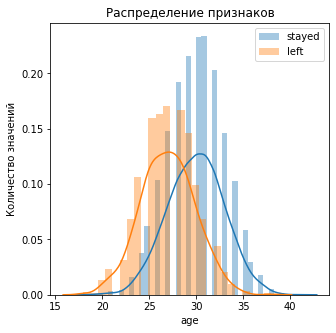

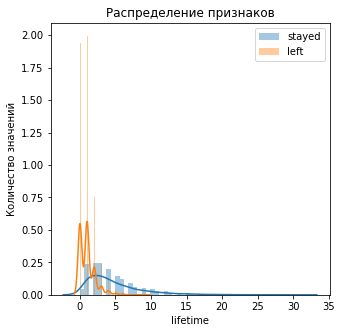

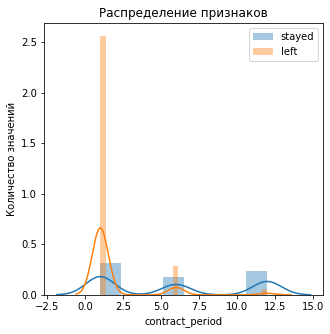

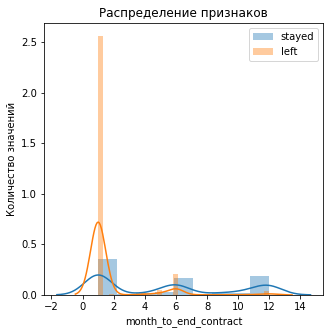

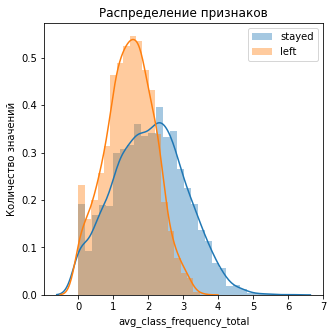

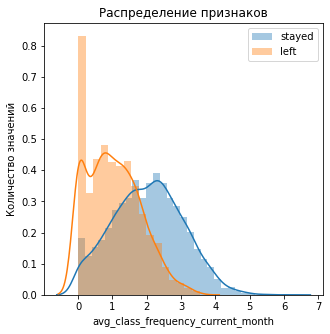

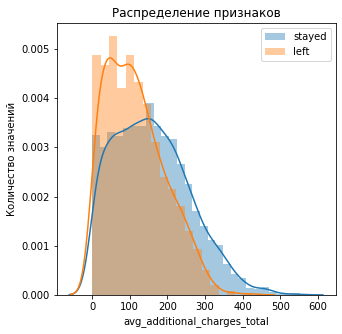

In [16]:
for col in gym_num.columns:
    plt.figure(figsize=(5,5))
    sns.distplot(gym_stayed_num[col], label="stayed")
    sns.distplot(gym_left_num[col], label="left")
    plt.title('Распределение признаков')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend(loc = 'upper right'); 

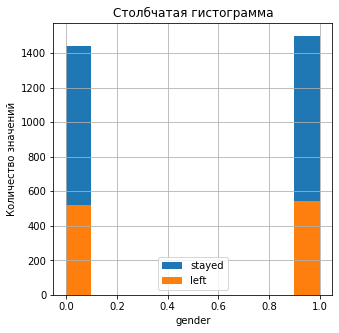

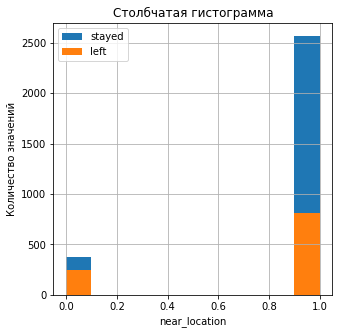

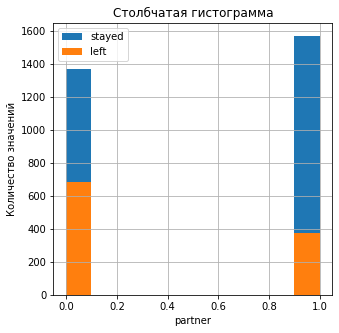

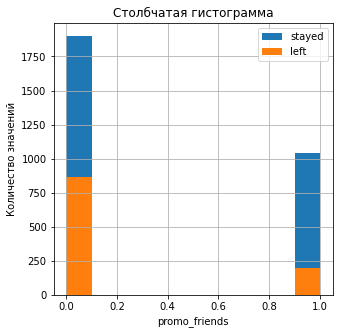

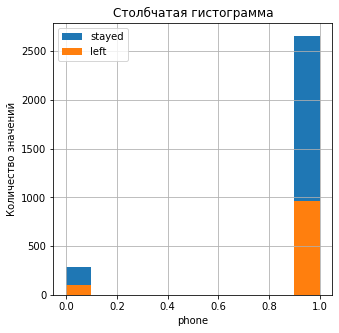

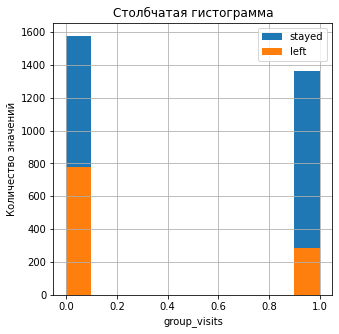

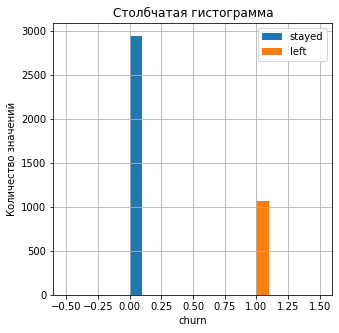

In [17]:
for col in gym_bool.columns:
    plt.figure(figsize=(5,5))
    gym_stayed_bool[col].hist(label = 'stayed')
    gym_left_bool[col].hist(label = 'left')
    plt.title('Столбчатая гистограмма')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend();  

### Матрица корреляций:

Для завершения анализа также будет построена матрица корреляций:

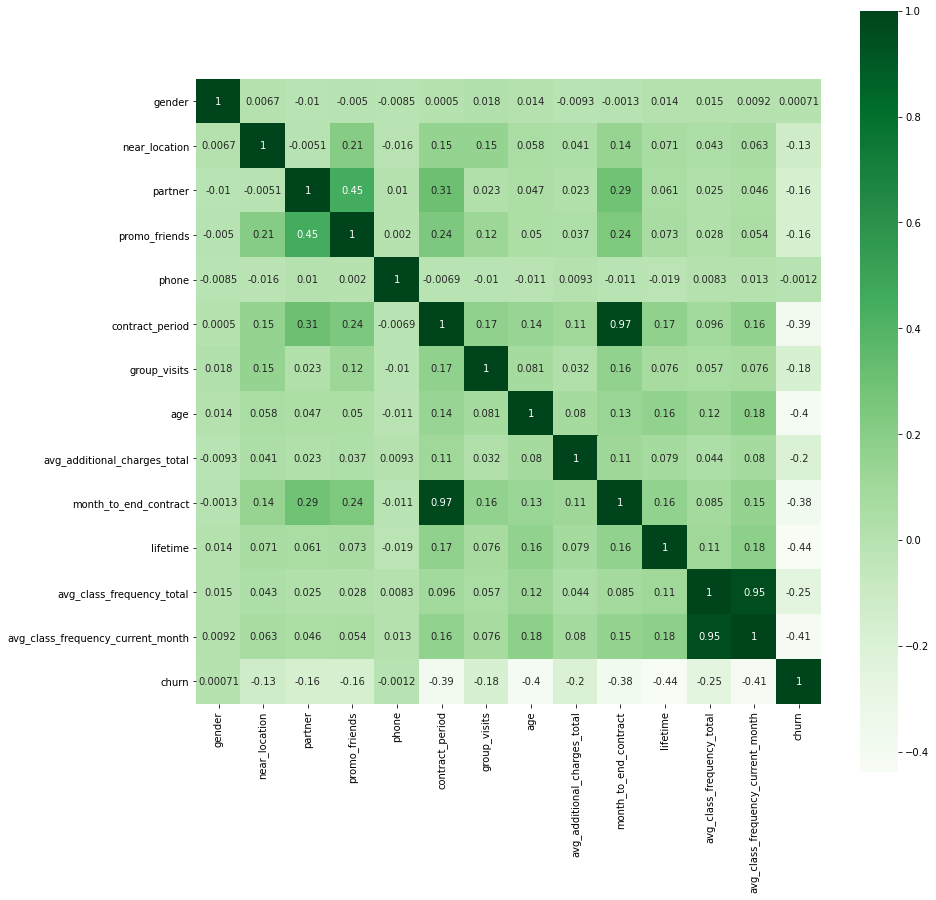

In [18]:
cor_mat = gym.corr() 
plt.figure(figsize=(14,14))
sns.heatmap(cor_mat, annot = True, square = True,cmap = 'Greens')          
plt.show()

Всего есть четыре "признака", которые попарно сильно коррелируют друг с другом:
* признаки "Contract_period" и "Month_to_end_contract" - коэффициент корреляции составляет 0,97;
* признаки "Avg_class_frequency_total" и "Avg_class_frequency_current_month" - коэффициент корреляции составляет 0,95.

**Промежуточные выводы:**
* тип всех имеющихся в датасете признаков - числовые, категориальных нет;
* пол пользователя и факт предоставления номера телефона почти не оказывают влияния на то, уйдёт клиент в отток или останется;
* живущие или работающие рядом с фитнес-залом клиенты реже уходят в отток;
* клиенты, ушедшие в отток, реже пользовались промокодами или специальными предложениями при первом обращении в фитнес-зал;
* длительность текущего абонемента у остающихся клиентов заметно выше, чем у ушедших в отток;
* посещающие групповые занятия клиенты намного реже уходят в отток;
* средний возраст клиентов, ушедших в отток - 27 лет. У оставшихся он выше - 30 лет;
* ушедшие в отток клиенты реже платили за дополнительные услуги;
* средняя частота посещения в неделю за все время с начала действия абонемента среди ушедших в отток ниже, чем у остающихся - как в целом, так и за предыдущий месяц;
* всего есть четыре "признака", которые попарно сильно коррелируют друг с другом.

## Построение модели прогнозирования оттока клиентов

Следующий шаг - построение модели бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце. 
Построение будет состоять из нескольких этапов.

**Этап 1: Разбивка данные на обучающую и валидационную выборку.**

In [19]:
X = gym.drop('churn', axis = 1) 
y = gym['churn']
X 

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91
2,0,1,1,0,1,1,0,28,129.45,1.00,2,1.86,1.74
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36
4,1,1,1,1,1,1,0,26,198.36,1.00,3,1.11,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35
3996,0,1,0,0,1,1,1,29,68.88,1.00,1,1.28,0.29
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83
3998,0,1,1,1,1,6,0,32,61.91,5.00,3,1.63,1.60


In [20]:
y

0       0
1       0
2       0
3       0
4       0
       ..
3995    0
3996    1
3997    0
3998    0
3999    0
Name: churn, Length: 4000, dtype: int64

Разбивка данных на обучающую и валидационную выборку.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)  
X_test_st = scaler.transform(X_test) 

Обучение моделей на train-выборке двумя способами: логистической регрессией и случайным лесом.
Оценка метрик accuracy, precision и recall для обеих моделей на валидационной выборке:

In [22]:
models = [
    LogisticRegression(solver='liblinear'),
    DecisionTreeClassifier(random_state=0),
]

def predict_future(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    prediction = model.predict(X_test) 
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_test, prediction)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_test, prediction)))
    print('\tRecall: {:.2f}'.format(recall_score(y_test, prediction)))

In [23]:
for s in models:
    print(s)
    predict_future(s, X_train, y_train, X_test, y_test)

LogisticRegression(solver='liblinear')
	Accuracy: 0.93
	Precision: 0.86
	Recall: 0.83
DecisionTreeClassifier(random_state=0)
	Accuracy: 0.90
	Precision: 0.79
	Recall: 0.80


Логистическая регрессия показала в данном случае лучшие результаты на основании метрик. 

## Кластеризация клиентов

Последний вид проводимого в рамках исследования анализа - кластеризация клиентов и изучение признаков получившихся кластеров.
Стандартизация данных и определение оптимального количества кластеров:

In [24]:
scaler = StandardScaler()
gym_sc = scaler.fit_transform(X)

gym_linked = linkage(gym_sc, method = 'ward') 

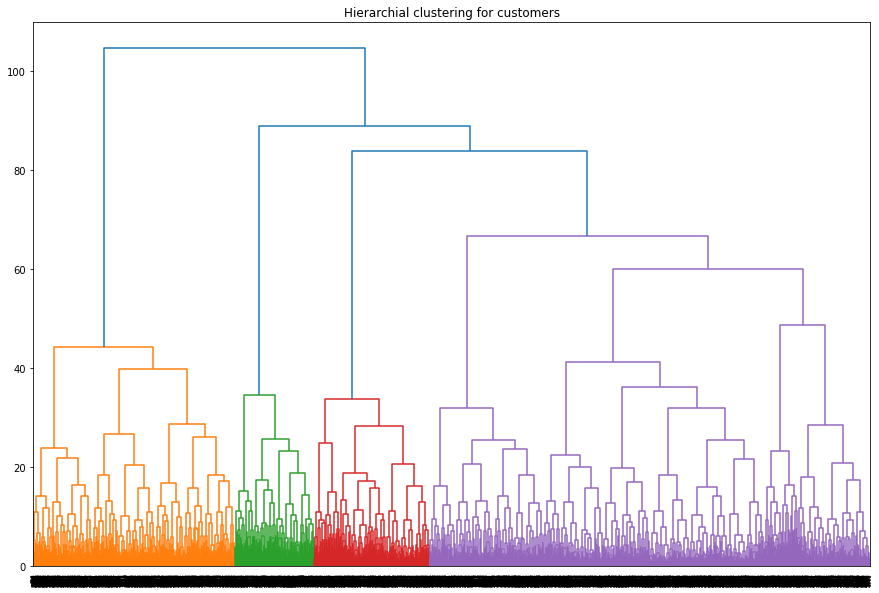

In [25]:
plt.figure(figsize=(15, 10))  
dendrogram(gym_linked, orientation='top')
plt.title('Hierarchial clustering for customers')
plt.show() 

Порог расстояний можно определить по-разному, в рамках данной работы будут выделены 5 кластеров.

Обучение модели кластеризации на основании алгоритма K-Means:

In [26]:
kmn = KMeans(n_clusters=5, random_state=0)

labels =  kmn.fit_predict(gym_sc)
gym['cluster'] = labels

Средние значения признаков для кластеров:

In [27]:
gym_mean = gym.groupby('cluster').mean()
gym_mean 

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


На основании данных значений можно сделать первые выводы:
* Во всех пяти кластерах примерно одинаковое количество мужчин и женщин, средний возраст среди кластеров тоже не сильно различается (максимальная разница составляет менее 2 лет);
* В первом кластере среднее количество месяцев до конца контракта более, чем в два раза превышает аналогичный показатель в любом другом кластере. При этом 57% использовали промо-код от знакомого при оплате первого абонемента, что также является рекордно высоким значением среди кластеров. У этого кластера также самый низкий показатель оттока - всего 3%;
* Во втором кластере ни один из клиентов не оставил номер телефона;
* В третьем кластере ни один пользователь не живёт и не работает рядом с фитнес-центром, а количество клиентов, которые использовали промо-код от знакомого при оплате первого абонемента, минимально - всего 8%, в отличие от остальных групп, где таких клиентов от 23% до 57%. У этого кластера также самый низкий показатель посещения групповых занятий - всего 22%. Показатель оттока один из самых высоких - 44%;
* В четвёртом кластере все пользователи живут и/или работают рядом с фитнес-центром, и в среднем заключают контракт всего на 2 месяца. При этом у кластера самый высокий показатель оттока - 51%;
* Наконец, у пятого кластера, помимо крайне низкого показателя оттока (7%), самый высокий средний возраст среди клиентов, которые живут либо работают почти все рядом с фитнес-залом (98%) и гораздо чаще клиентов из других кластеров посещают занятия (почти 3 раза в неделю).

В конце анализа для большей наглядности будут построены распределения признаков для числовых (не логических) значений. Алгоритм создания новых датафреймов перед отрисовкой графики аналогичен тому, что проводился в Главе 2, с той лишь разницей, что будет проведено дополнительное деление по кластерам.

Создание отдельных датафреймов по каждому кластеру:

In [28]:
gym_cluster_1 = gym[gym['cluster'] == 0] 
gym_cluster_2 = gym[gym['cluster'] == 1] 
gym_cluster_3 = gym[gym['cluster'] == 2]
gym_cluster_4 = gym[gym['cluster'] == 3] 
gym_cluster_5 = gym[gym['cluster'] == 4] 
gym_cluster_1.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
count,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00,1010.00
mean,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03,0.00
std,0.50,0.20,0.41,0.49,0.00,2.33,0.50,3.10,99.94,2.56,3.92,0.93,0.93,0.16,0.00
min,0.00,0.00,0.00,0.00,1.00,6.00,0.00,20.00,0.25,2.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,1.00,0.00,1.00,12.00,0.00,28.00,77.68,8.00,2.00,1.32,1.34,0.00,0.00
50%,1.00,1.00,1.00,1.00,1.00,12.00,1.00,30.00,156.46,11.00,4.00,2.01,2.01,0.00,0.00
75%,1.00,1.00,1.00,1.00,1.00,12.00,1.00,32.00,231.32,12.00,6.00,2.65,2.64,0.00,0.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,38.00,552.59,12.00,31.00,5.08,4.98,1.00,0.00


In [29]:
gym_cluster_5['cluster'].describe()

count   838.00
mean      4.00
std       0.00
min       4.00
25%       4.00
50%       4.00
75%       4.00
max       4.00
Name: cluster, dtype: float64

Быстрая проверка двух кластеров показала, что кластеры созданы правильно.

Разделение клиентов каждого кластера на тех, кто остался, и тех, кто ушёл в отток:

In [30]:
gym_cluster_1_stayed = gym_cluster_1[gym_cluster_1['churn'] == 0]
gym_cluster_1_left = gym_cluster_1[gym_cluster_1['churn'] == 1]

gym_cluster_2_stayed = gym_cluster_2[gym_cluster_2['churn'] == 0]
gym_cluster_2_left = gym_cluster_2[gym_cluster_2['churn'] == 1]

gym_cluster_3_stayed = gym_cluster_3[gym_cluster_3['churn'] == 0]
gym_cluster_3_left = gym_cluster_3[gym_cluster_3['churn'] == 1]

gym_cluster_4_stayed = gym_cluster_4[gym_cluster_4['churn'] == 0]
gym_cluster_4_left = gym_cluster_4[gym_cluster_4['churn'] == 1]

gym_cluster_5_stayed = gym_cluster_5[gym_cluster_5['churn'] == 0]
gym_cluster_5_left = gym_cluster_5[gym_cluster_5['churn'] == 1]

gym_cluster_1_stayed

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn,cluster
1,0,1,0,0,1,12,1,31,113.20,12.00,7,1.92,1.91,0,0
3,0,1,1,1,1,12,1,33,62.67,12.00,2,3.21,3.36,0,0
15,0,1,1,1,1,12,0,29,101.37,10.00,4,2.85,2.84,0,0
19,1,1,1,1,1,12,1,29,73.92,11.00,14,1.14,1.16,0,0
22,1,1,0,0,1,12,1,29,100.16,12.00,1,3.90,3.71,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,0,1,0,0,1,12,1,25,33.12,12.00,2,0.80,0.96,0,0
3992,0,1,1,1,1,12,0,31,223.10,8.00,4,3.86,3.80,0,0
3995,1,1,1,0,1,12,0,33,2.41,12.00,8,2.28,2.35,0,0
3997,1,1,1,1,1,12,0,28,78.25,11.00,2,2.79,2.83,0,0


Создание пяти датасетов по пяти кластерам, содержащим информацию только о числовых (не логических) значениях.

In [31]:
gym_cluster_1_stayed_num = gym_cluster_1_stayed[gym_cluster_1_stayed.isin(gym_num)].dropna(axis=1)
gym_cluster_1_left_num = gym_cluster_1_left[gym_cluster_1_left.isin(gym_num)].dropna(axis=1)

gym_cluster_2_stayed_num = gym_cluster_2_stayed[gym_cluster_2_stayed.isin(gym_num)].dropna(axis=1)
gym_cluster_2_left_num = gym_cluster_2_left[gym_cluster_2_left.isin(gym_num)].dropna(axis=1)

gym_cluster_3_stayed_num = gym_cluster_3_stayed[gym_cluster_3_stayed.isin(gym_num)].dropna(axis=1)
gym_cluster_3_left_num = gym_cluster_3_left[gym_cluster_3_left.isin(gym_num)].dropna(axis=1)

gym_cluster_4_stayed_num = gym_cluster_4_stayed[gym_cluster_4_stayed.isin(gym_num)].dropna(axis=1)
gym_cluster_4_left_num = gym_cluster_4_left[gym_cluster_4_left.isin(gym_num)].dropna(axis=1)

gym_cluster_5_stayed_num = gym_cluster_5_stayed[gym_cluster_5_stayed.isin(gym_num)].dropna(axis=1)
gym_cluster_5_left_num = gym_cluster_5_left[gym_cluster_5_left.isin(gym_num)].dropna(axis=1)

gym_cluster_1_stayed_num

,contract_period,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
1,12,31,113.20,12.00,7,1.92,1.91
3,12,33,62.67,12.00,2,3.21,3.36
15,12,29,101.37,10.00,4,2.85,2.84
19,12,29,73.92,11.00,14,1.14,1.16
22,12,29,100.16,12.00,1,3.90,3.71
...,...,...,...,...,...,...,...
3988,12,25,33.12,12.00,2,0.80,0.96
3992,12,31,223.10,8.00,4,3.86,3.80
3995,12,33,2.41,12.00,8,2.28,2.35
3997,12,28,78.25,11.00,2,2.79,2.83


Построение графиков для каждого кластера.
Кластер 1:

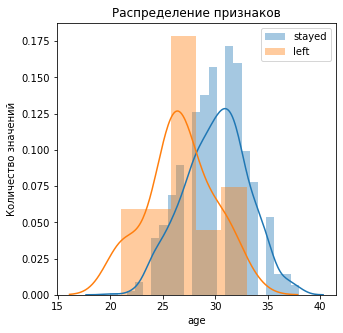

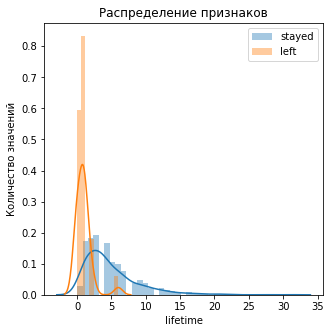

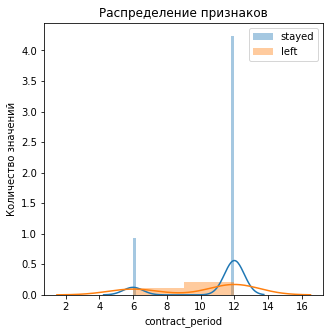

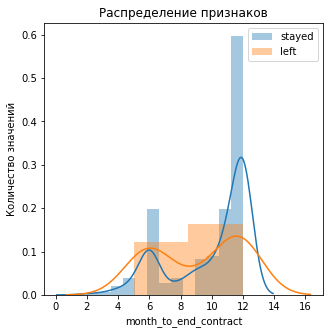

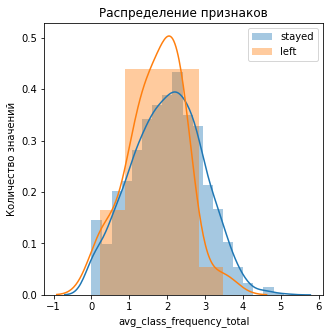

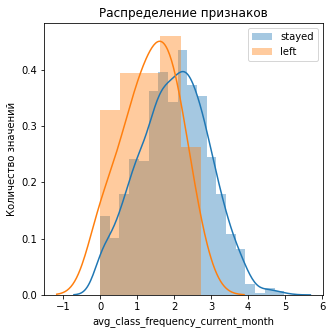

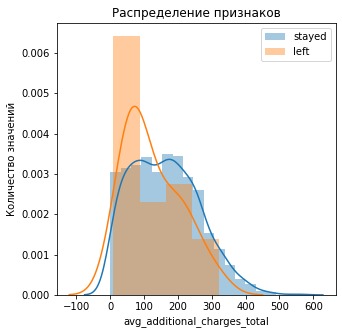

In [32]:
for col in gym_num.columns:
    plt.figure(figsize=(5,5))
    sns.distplot(gym_cluster_1_stayed_num[col], label="stayed")
    sns.distplot(gym_cluster_1_left_num [col], label="left")
    plt.title('Распределение признаков')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend(loc = 'upper right'); 

Графики показывают следующее:
* Ушедшие в отток клиенты в целом моложе тех (самые частые значения: 26-27 лет), кто остался (29-33 года);
* Время с момента первого обращения в фитнес-центр у уходящих клиентов очень небольшое, обычно всего 1-2 месяца. Люди быстро теряют интерес к занятиям и уходят. У остающихся клиентов этот показатель намного выше;
* Большая часть клиентов, которая осталась, заключала контракты на 12 и 6 месяцев. Клиенты, ушедшие в отток, заключали контракт на срок от 6 до 12 месяцев, при этом клиентов, заключивших контракт на срок от 9 до 12 месяцев, было больше;
* У ушедших в отток клиентов остаётся до конца контракта меньше месяцев, чем у тех, кто остаётся;
* Средняя частота посещения занятий у обеих групп клиентво не сильно отличается;
* Средняя частота посещений в неделю за предыдущий месяц у остающихся клиентов, как правило, выше, чем у уходящих в отток (что выглядит логично, так как люди теряют интерес к занятиям постепенно);
* Остающиеся клиенты тратят на дополнительные услуги в фитнес-центре больше денег, чем ушедшие в отток.

Показатели клиентов кластера №2:

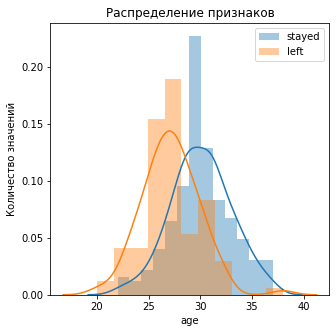

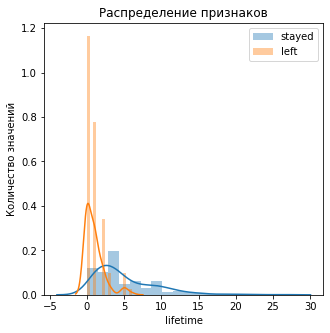

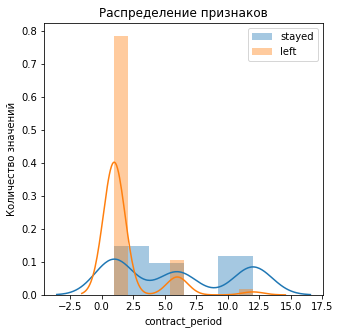

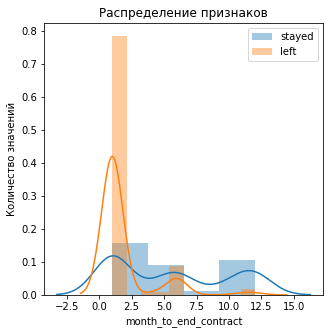

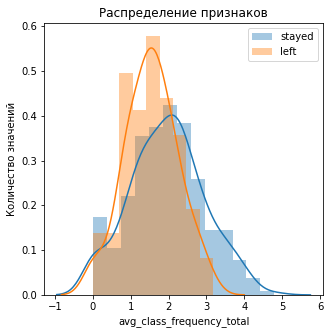

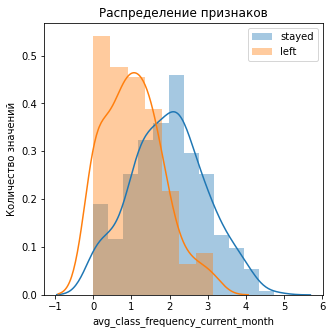

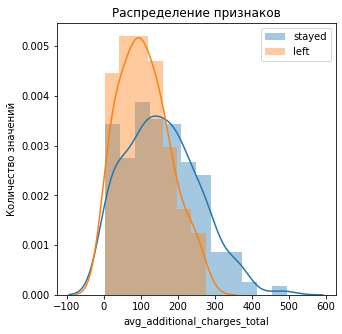

In [33]:
for col in gym_num.columns:
    plt.figure(figsize=(5,5))
    sns.distplot(gym_cluster_2_stayed_num[col], label="stayed")
    sns.distplot(gym_cluster_2_left_num [col], label="left")
    plt.title('Распределение признаков')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend(loc = 'upper right'); 

* Те, кто остался, в целом старше тех, кто ушёл (29-32 года против 25-27 лет);
* У уходящих клиентов с момента первого обращения в фитнес-центр проходило 1-2, реже 3 месяца. Больше 5 месяцев среди уходящих клиентов почти никого нет. В то же время среди оставшихся клиентов с момента первого обращения могло пройти и более 10 месяцев;
* У ушедших в отток клиентов продолжительность контракта обычно составляла 2 месяца, гораздо реже - 6, и очень редко - до 1 года. У оставшихся клиентов этот показатель был распределён более равномерно между 2 и 12 месяцами. Очень схожие показатели у признака "срок до окончания текущего действующего абонемента" - такое чувство, что ушедшие клиенты почти сразу же потеряли интерес к занятиям;
* У уходящих клиентов средняя частота посещения занятий и средняя частота посещений в неделю за предыдущий месяц меньше, чем у остающихся, причём за предыдущий месяц показатели заметно ниже;
* Ушедшие тратили в фитнес-зале на дополнительные услуги меньше денег, чем оставшиеся.

Кластер № 3.

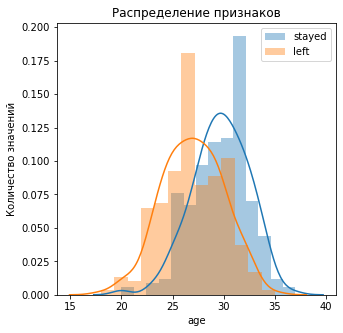

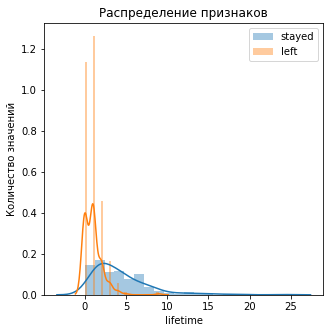

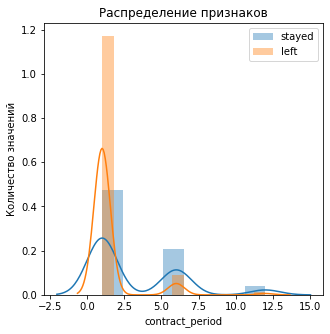

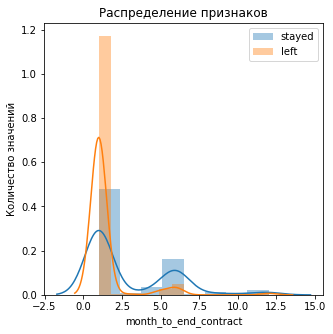

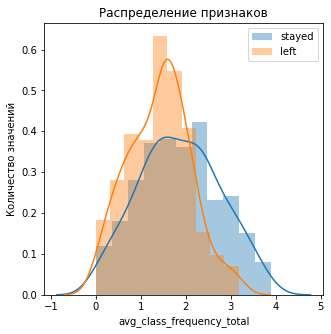

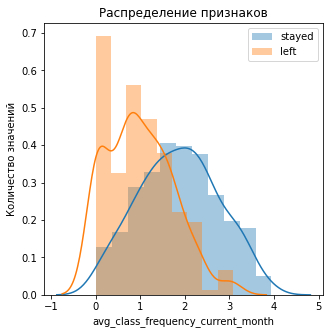

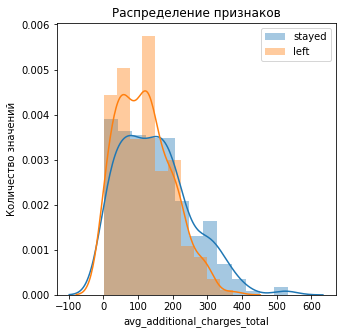

In [34]:
for col in gym_num.columns:
    plt.figure(figsize=(5,5))
    sns.distplot(gym_cluster_3_stayed_num[col], label="stayed")
    sns.distplot(gym_cluster_3_left_num [col], label="left")
    plt.title('Распределение признаков')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend(loc = 'upper right'); 

Наблюдаются следующие тенденции:
* Большинству уходящих в отток клиентов - 27 лет. Тем, кто остаётся- 32 года. В целом уходящие клиенты моложе остающихся;
* Время с момента первого обращения в фитнес-центр у ушедших в отток клиентов редко когда превышает пять месяцев, при этом у большинства клиентов оно и вовсе составляет не более одного-двух месяцев;
* В основном уходят клиенты с длительностью контакта до 2 месяцев, намного реже длительность контракта составляет 6 месяцев и почти никогда - 12. Среди остающихся клиентов намного больше тех, кто заключил контракт продолжительностью более чем 6 месяцев;
* У ушедщих в отток клиентов оставалось меньше месяцев до конца контракта, чем у остающихся (2 месяца против 2-6 месяцев соответственно);
* Ушедшие в отток клиенты реже оставшихся посещали фитнес-зал, включая последний месяц перед уходом. При этом за последний месяц перед уходом показатели ушедших клиентов сильно ниже, чем за всё время посещения фитнес-зала;
* Уходящие клиенты платили меньше денег за дополнительные услуги;

Время взглянуть на предпоследний, кластер №4:

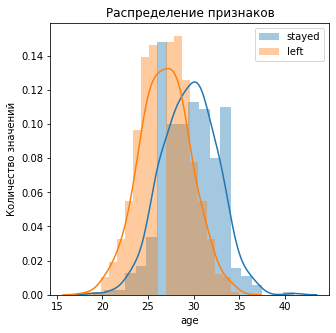

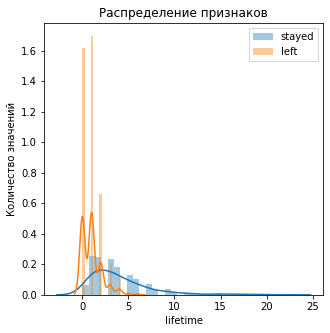

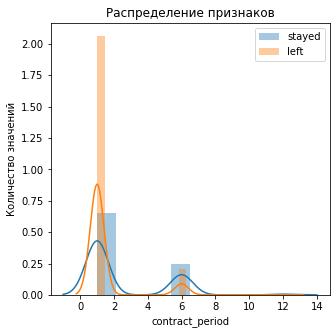

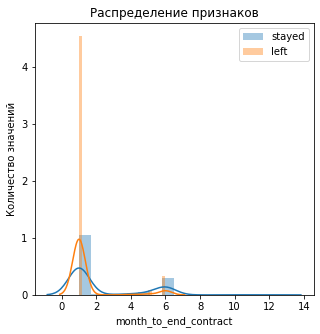

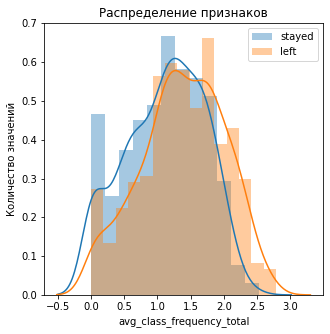

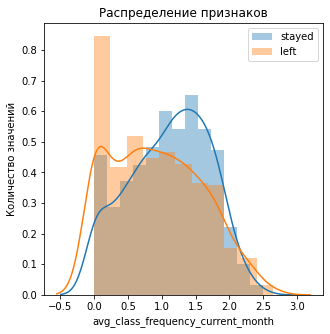

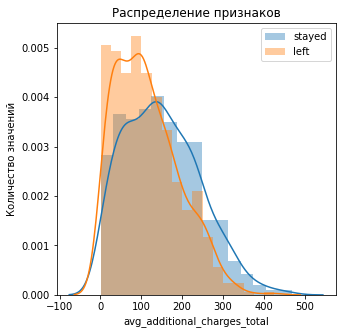

In [35]:
for col in gym_num.columns:
    plt.figure(figsize=(5,5))
    sns.distplot(gym_cluster_4_stayed_num[col], label="stayed")
    sns.distplot(gym_cluster_4_left_num [col], label="left")
    plt.title('Распределение признаков')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend(loc = 'upper right'); 

* Остающиеся клиенты снова старше уходящих в отток, но есть одно исключение - все клиенты в возрасте 26 лет в данном кластере остались;
* Время с момента первого обращения в фитнес-центр у большинства ушедших в отток составляло до 3 месяцев, чаще всего это было 2 месяца или 1.
* Большая часть ушедших в отток клиентов заключала контракт продолжительностью 1 месяц, реже - 6 месяцев. Остающиеся клиенты заключали их примерно на тот же срок: либо 1-2 месяца, либо 5-7;
* У большинства ушедших в отток клиентов до конца контракта оставался 1 месяц;
* В отличие от других кластеров, в среднем оставшиеся клиенты посещали фитнес-зал *реже*, чем ушедшие в отток;
* А вот аналогичные показатели за прошлый месяц у ушедших в отток очень часто составляли 0, то есть клиент вообще переставал ходить в зал;
* Остающиеся клиенты тратили больше денег на дополнительные сервисы;

Наконец, финальный, кластер №5:

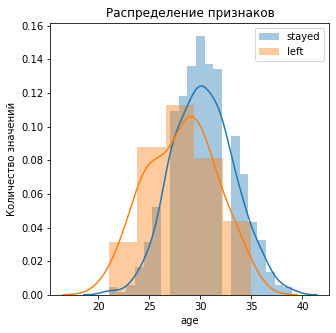

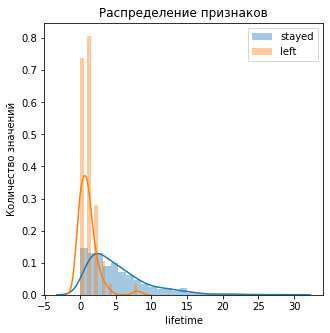

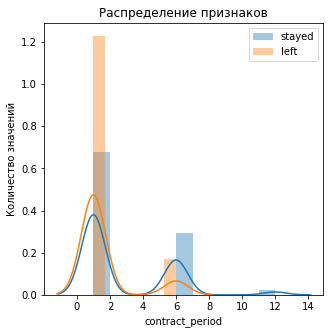

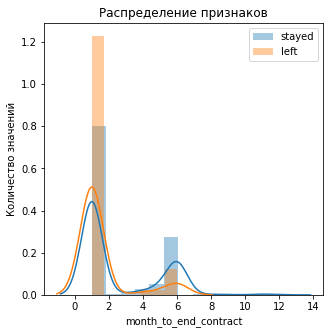

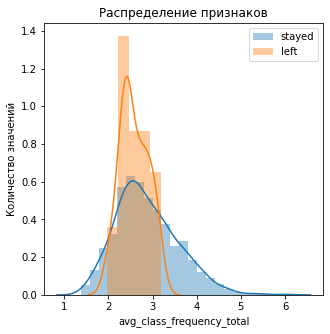

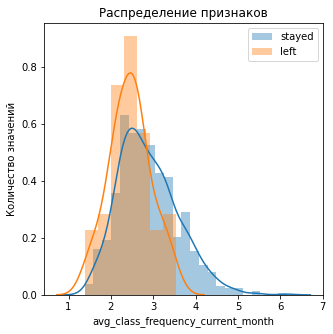

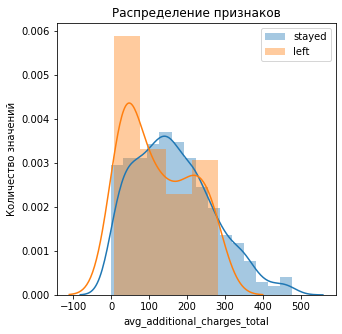

In [36]:
for col in gym_num.columns:
    plt.figure(figsize=(5,5))
    sns.distplot(gym_cluster_5_stayed_num[col], label="stayed")
    sns.distplot(gym_cluster_5_left_num [col], label="left")
    plt.title('Распределение признаков')
    plt.xlabel(col) 
    plt.ylabel('Количество значений')
    plt.legend(loc = 'upper right'); 

* Ушедшие в отток клиенты моложе тех, кто остался;
* Время с момента первого обращения в фитнес-центр у ушедших в отток составляет не более 3 месяцев, обычно 1 или 2;
* Продолжительность контракта у ушедших в отток в большинстве случаев не превышает 2 месяцев;
* У большинства ушедших в отток остаётся не более 2 месяцев до конца контракта. У остающихся цифра либо такая же, либо составляет 5-6 месяцев;
* Интересная статистика у средней частоты посещений в неделю за все время с начала действия абонемента: среди ушедших в отток лидируют значения между 2 и 3, а у остающихся эти значения рапсределены более равномерно, хотя диапазон от 2,2 до 3 также остаётся самым часто встречаемым среди оставшихся клиентов;
* Средняя частота посещений в неделю за предыдущий месяц у ушедших в отток немного ниже, чем за всё время посещения фитнес-центра, хотя всё ещё на высоком уровне: от 1,5 до 3,5 раз, причём максимально часто встречаемый диапазон - от 2 до 3 раз. В то же время у остающихся клиентов этот показатель выше - от 1,5 до 5 раз в неделю;
* Ушедшие в отток тратят намного меньше денег, чем остающиеся, часто это значение вообще равно 0;

Финальный шаг - ещё раз посмотреть на процент ушедших в отток клиентов в каждом кластере:

In [37]:
gym_churn_rate = gym.groupby('cluster')['churn'].mean().sort_values(ascending = False)
gym_churn_rate

cluster
3   0.51
2   0.44
1   0.27
4   0.07
0   0.03
Name: churn, dtype: float64

График для наглядности:

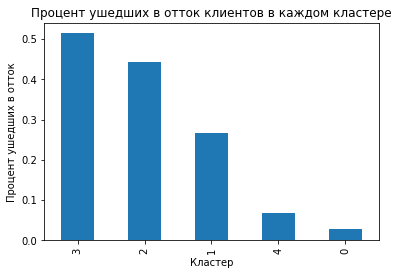

In [38]:
gym_churn_rate.plot(title = 'Процент ушедших в отток клиентов в каждом кластере', 
xlabel = 'Кластер', ylabel= 'Процент ушедших в отток', kind='bar');

Больше всего клиентов ушло в 4-й группе (51%), на втором месте 3-я (44%). Третье место за 2-й (27%), следом идёт 5-я (7%). Замыкает список первая группа - всего 3% оттока.

Таким образом, самыми надёжными являются кластеры №1 и №5, а больше всего склонны к оттоку клиенты из кластеров №4 и №3. 

## Выводы и базовые рекомендации

Для более удобного восприятия результатов таблица со средними значениями будет загружена ещё раз.

In [39]:
gym_mean 

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.50,0.96,0.78,0.57,1.00,10.89,0.54,29.98,160.76,9.95,4.74,1.98,1.97,0.03
1,0.52,0.86,0.47,0.31,0.00,4.79,0.43,29.30,143.96,4.48,3.92,1.85,1.72,0.27
2,0.50,0.00,0.46,0.08,1.00,2.35,0.22,28.48,135.46,2.20,2.81,1.66,1.48,0.44
3,0.49,1.00,0.35,0.24,1.00,1.95,0.34,28.17,131.62,1.86,2.44,1.25,1.01,0.51
4,0.56,0.98,0.36,0.23,1.00,2.67,0.47,30.13,161.66,2.46,4.90,2.85,2.85,0.07


Анализ клиентов фитнес-зала показал следующие результаты:

* Пол не играет почти никакой роли;
* Самые надёжные кластеры - №1 и №5. Они отличаются следующими характеристиками:
    * Почти все клиенты этих кластеров либо живут, либо работают рядом с фитнес-залом (96% и 98% соответственно);
    * Большая часть клиентов в этих группах пришла либо по промокоду от друзей, либо благодаря сотрудничеству работодателя с фитнес-залом;
    * Все оставляли свои номера телефонов (100%);
    * А вот продолжительность контракта сильно различалась: если в группе №1 она составляла в среднем 10,9 месяцев, что сильно выделяет этот кластер на фоне остальных, то у группы №5 - 2,7 месяца;
    * Процент факта посещения групповых занятий самый высокий среди кластеров - 54% и 47% соответственно;
    * Также эти группы являются лидерами по среднему возрасту - 30,1 и 30 лет;
    * Участники этих клатеров оставляли больше всего денег за дополнительные услуги;
    * Срок до окончания текущего действующего абонемента - 10 и 2,5 месяца соотвественно;
    * Время с момента первого обращения в фитнес-центр самое высокое среди кластеров - 4,7 и 4,9 месяцев;
    * Клиенты обоих кластеров чаще всего ходят в фитнес-зал (включая последний месяц).
    
* Самые ненадёжные клиенты - в кластерах №3 и №4:
    * В кластере №3 нет ни одного клиента, который бы жил или работал рядом с фитнес-центром, в то время как в кластере №4 живут и/или работают рядом с фитнес-центром 100% клиентов;
    * Показатели по использованию промокодов и/или предложений от работодателей - одни из самых низких среди кластеров, у кластера №3 это 46% (партнёрская программа) и 8% (промокоды от друзей), у кластера №4 - 35% и 24% соответственно; 
    * Все оставляли свои номера телефонов (100%);
    * Средняя продолжительность контракта - 2,4 и 2 месяца соответственно;
    * Процент факта посещения групповых занятий самый низкий среди кластеров - 22% и 34% соответственно;
    * Средний возраст также самый низкий среди кластеров - 28,5 и 28,2 лет соответственно;
    * Клиенты данные кластеров меньше всего платили за дополнительные услуги;
    * Срок до окончания текущего действующего абонемента - 2,2 и 1,9 месяца соответственно; 
    * Среднее количество занятий в неделю у кластеров сравнительно низкое: 1,3-1,7 занятий в неделю. Ещё хуже с аналогичными показателями за предыдущий месяц - 1,5 и 1 соответственно.
    
На основании всего вышеперечисленного можно дать рекомендации для стратегии взаимодействия с клиентами и их удержания. В то время как с привлечением клиентов проблем особо не наблюдается (многие клиенты пользовались специальными предложениями, когда пришли в первый раз, то есть рекламные компании работают, хотя анализ их успешности не является частью данного исследования), основная проблема - выбрать "правильных" с точки зрения бизнеса клиентов, а затем их удержать:

* Пол и факт предоставления номера телефона не играют особой роли, их можно игнорировать;
* Рекомендуется сосредочить усилия на привлечение клиентов старше 29-30 лет - они гораздо реже уходят в отток и платят больше денег за дополнительные услуги; 
* Группа, в которой нет ни одного клиента, который бы жил или работал рядом с фитнес-центром, имеет один из самых высоких показателей оттока. Рекомендуется сосредоточить свои усилия по поиску новых клиентов среди жителей-работников ближащих к фитнес-центру зданий;
* Клиенты, заключающие контракты на продолжительный срок - более полугода - намного менее склонны уйти в отток, чем клиенты, покупающие абонементы на несколько месяцев, хотя среди таких клиентов также далеко не все уходят в отток. Рекомендуется сосредоточиться на продаже именно долгосрочных контрактов;
* Факт участия в групповых занятиях сильно повышает шанс на то, что человек не уйдёт в отток, вероятно, из-за социального общения в группе. Рекомендуется более интенсивно рекламировать именно групповые занятия с целью удержания клиентов;
* Наконец, рекомендуется стимулировать клиентов чаще приходить в фитнес-центр, так как анализ показывает, что интерес к занятиям пропадает постепенно: уходящие в отток клиенты реже посещают тренировки, а в последний месяц перед уходом в отток число посещений у данных клиентов падает ещё сильнее, иногда до нуля.

В случае построения модели прогнозирования оттока клиентов рекомендуется использовать логистическую регрессию, так как она показала лучшие результаты на основании метрик. 